# Fake News Detection
**Name:** Daniel Mwaka

**Group:** Group 2B

## Introduction

## Data Loading, Feature Engineering, and Preprocessing

### Data Loading

In [1]:
# Import basic libraries
import pandas as pd  
import numpy as np  
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import io

# Import NLP tools and NLTK library modules
import nltk 
from nltk.corpus import stopwords, wordnet 
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer 
from nltk import pos_tag  
from nltk.util import bigrams
from nltk.util import trigrams
import string  
import re 
import spacy

# Import scikit-learn library's classes, tools, and modules 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, auc, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib
from gensim.models import Word2Vec

# Import tensorflow, and keras modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout, Dense, LSTM, Input, Masking

# Import transformers and pytorch modules
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch
from torch.utils.data import Dataset


# Disable warnings
import warnings
warnings.filterwarnings('ignore')

2025-08-01 02:53:08.578549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754016788.783966      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754016788.840695      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# !pip install accelerate

In [2]:
data = pd.read_csv("/kaggle/input/data-csv/data.csv")
data.head()

,news_url,title,extracted_article_text,news_type,class
0,https://www.bustle.com/p/will-the-royals-retur...,Will 'The Royals' Return For Season 5? This St...,Entertainment With a royal wedding and a coup ...,gossip,1
1,https://www.foxnews.com/entertainment/naya-riv...,Naya Rivera refiles for divorce from Ryan Dors...,"This material may not be published, broadcast,...",gossip,1
2,https://www.unitedbypop.com/style/fashion/tayl...,Outfit ideas for Taylor Swift's Reputation Tour,United By Pop - United Kingdom. United States....,gossip,1
3,https://variety.com/2018/music/news/scott-hutc...,Scott Hutchison Dead: Frightened Rabbit Frontm...,By Robert Mitchell A body found Thursday night...,gossip,1
4,https://www.etonline.com/kate-middleton-gives-...,Kate Middleton Gives Birth to Royal Baby No. 3...,Baby No. 3 is officially here! Kate Middleton ...,gossip,1


In [3]:
# Check shape
data.shape

(16044, 5)

In [4]:
# Check duplicates
data.duplicated().sum()

928

In [6]:
# Drop duplicates
data.drop_duplicates(inplace=True)

In [7]:
# Confirm no duplicates
data.duplicated().sum()

0

In [8]:
# Inspect column attributes to check missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15116 entries, 0 to 16043
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   news_url                15116 non-null  object
 1   title                   15116 non-null  object
 2   extracted_article_text  15116 non-null  object
 3   news_type               15116 non-null  object
 4   class                   15116 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 708.6+ KB


- Data was successfully loaded and duplicates removed. 
- There are no entries with missing values

### Feature Engineering

In [9]:
# Engineer the domain feature
from urllib.parse import urlparse
data['domain'] = data['news_url'].apply(lambda x: urlparse(x).netloc if isinstance(x, str) and urlparse(x).netloc else 'missing')

# Engineer the article feature
data['article'] = data['title'] + " " + data['extracted_article_text']

# Engineer the text length 
data['num_sentences']=data['extracted_article_text'].apply(lambda x: len(sent_tokenize(x)))

# Engineer the text length 
data['text_length']=data['extracted_article_text'].apply(lambda x: len(x.split()))
data.head(2)

,news_url,title,extracted_article_text,news_type,class,domain,article,num_sentences,text_length
0,https://www.bustle.com/p/will-the-royals-retur...,Will 'The Royals' Return For Season 5? This St...,Entertainment With a royal wedding and a coup ...,gossip,1,www.bustle.com,Will 'The Royals' Return For Season 5? This St...,39,693
1,https://www.foxnews.com/entertainment/naya-riv...,Naya Rivera refiles for divorce from Ryan Dors...,"This material may not be published, broadcast,...",gossip,1,www.foxnews.com,Naya Rivera refiles for divorce from Ryan Dors...,30,368


In [10]:
data['domain'].value_counts().nlargest(5)

domain
missing                3237
people.com             1224
www.dailymail.co.uk     682
www.etonline.com        536
www.usmagazine.com      512
Name: count, dtype: int64

### Data Preprocessing

- Define a function for **_text cleaning, normalization, word tokenizing, Part-of-Speech tagging, lemmatization_** and **_removing stopwords_**, using Regular Expressions (**re**), **NLTK**, and the **string** module. 

In [15]:
# nltk.download('averaged_perceptron_tagger_eng')

In [16]:
def clean_text(text):
    text = text.lower() # Lowercase all characters
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Drop URLs
    text = re.sub(r'\[.*?\]', '', text) # Remove content enclosed by []
    text = re.sub(r'<.*?>+', '', text) # Remove content enclosed with angle brackets
    text = re.sub(r'\n', ' ', text) # Replace newline characters with space to avoid merging words

    tokens = word_tokenize(text) # Tokenize the text into words
    tagged_tokens = pos_tag(tokens) # Apply POS tagging

    lemmatizer = WordNetLemmatizer() # Instantiate lemmatizer to reduce words to their base form

    # Define helper function to map NLTK's POS tags to WordNet's tags for lemmatization
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN # Default to noun if no clear mapping

    lemmatized_words = []
    for word, tag in tagged_tokens:
        wntag = get_wordnet_pos(tag)
        lemmatized_words.append(lemmatizer.lemmatize(word, wntag))

    stop_words = set(stopwords.words('english')) # Remove stopwords
    filtered_tokens_stopwords = [word for word in lemmatized_words if word not in stop_words]

    cleaned_tokens = [re.sub(r'[^a-zA-Z]', '', word) for word in filtered_tokens_stopwords] # Remove punctuation
    cleaned_tokens = [word for word in cleaned_tokens if word] # Remove empty strings that might result from cleaning 
    # word_tokens = [word for word in cleaned_tokens if not word.isdigit()] # Remove digits
    # final_tokens = [word for word in word_tokens if len(word) > 2] # Remove single-character and two-character words

    return cleaned_tokens
# Apply the clean_text function to the 'article' column  
data['nltk'] = data['article'].apply(clean_text)

In [ ]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  
# Define function to clean text using spaCy with chunking for large texts
def clean_text(text, debug=False):
    # Convert lists to strings if necessary
    if isinstance(text, list):
        text = " ".join(text)
    # Ensure text is a string
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()# Lowercase all characters    
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs    
    text = re.sub(r'\[.*?\]', '', text) # Remove content enclosed by square brackets
    text = re.sub(r'<.*?>+', '', text) # Remove content enclosed with angle brackets
    text = re.sub(r'\n', ' ', text) # Replace newline characters with space   
  
    # Define chunk size (under spaCy's default max_length of 1,000,000)
    chunk_size = 900000
    cleaned_tokens = []
    # Process text in chunks if it's too long
    if len(text) > chunk_size:
        chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
    else:
        chunks = [text]
    
    for chunk in chunks:
        doc = nlp(chunk)
        # Extract lemmatized tokens, excluding stopwords, punctuation, and digits
        for token in doc:
            if (not token.is_stop and 
                not token.is_punct):
                #not token.is_digit and 
                #len(token.lemma_) > 2):
                # Remove any remaining non-alphabetic characters from lemma
                cleaned = re.sub(r'[^a-zA-Z]', '', token.lemma_)
                if cleaned:  # Only include non-empty strings
                    cleaned_tokens.append(cleaned)
    return cleaned_tokens

# Apply the clean_text function to the 'spacy' column
data['spacy'] = data['article'].apply(lambda x: clean_text(x, debug=True))

In [24]:
# Join tokens 
data['spacy_text'] = data['spacy'].apply(lambda x: ' '.join(x))
data['nltk_text'] = data['nltk'].apply(lambda x: ' '.join(x))
data.head(2)

,news_url,title,extracted_article_text,news_type,class,domain,article,text_length,nltk,spacy,spacy_text,nltk_text,num_sentences
0,https://www.bustle.com/p/will-the-royals-retur...,Will 'The Royals' Return For Season 5? This St...,Entertainment With a royal wedding and a coup ...,gossip,1,www.bustle.com,Will 'The Royals' Return For Season 5? This St...,693,"[the, royal, return, season, story, far, enter...","[royal, return, season, story, far, entertainm...",royal return season story far entertainment ro...,the royal return season story far entertainmen...,39
1,https://www.foxnews.com/entertainment/naya-riv...,Naya Rivera refiles for divorce from Ryan Dors...,"This material may not be published, broadcast,...",gossip,1,www.foxnews.com,Naya Rivera refiles for divorce from Ryan Dors...,368,"[naya, rivera, refiles, divorce, ryan, dorsey,...","[naya, rivera, refile, divorce, ryan, dorsey, ...",naya rivera refile divorce ryan dorsey domesti...,naya rivera refiles divorce ryan dorsey domest...,30


In [25]:
# Preview a random sample (spacy)
data.iloc[99, 10]

'blac chyna cozy hot felon jeremy meek pic look like blac chyna hot felon jeremy meek work chyna share picture posing arm snapchat wednesday night show tattoo chyna don skintight lace orange dress meek keep casual camouflage print shirt rip jean news early snapchat post chyna appear photo shoot lead speculate possibly star campaign meek model attractive mugshot go viral headline summer relationship topshop heiress chloe green meek photograph kiss green luxury yacht coast turkey july married wife melissa time shortly picture surface meek file separation melissa year marriage news meek green shy pack pda watch video'

In [26]:
# Preview a random sample (nltk)
data.iloc[99, 11]

'blac chyna cozies hot felon jeremy meeks pic look like blac chyna hot felon jeremy meeks may something work together chyna share picture two pose arm around one another snapchat wednesday night show tattoo chyna skintight laceup orange dress meeks keep casual camouflageprint shirt rip jean news early snapchat post chyna appear photo shoot lead speculate two possibly star campaign together meeks become model attractive mugshot go viral make headline summer due relationship topshop heiress chloe green meeks photograph kiss green luxury yacht coast turkey july though still marry wife melissa time shortly picture surface meeks file separation melissa eight year marriage news since meeks green nt shy pack pda watch video'

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15116 entries, 0 to 16043
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   news_url                15116 non-null  object
 1   title                   15116 non-null  object
 2   extracted_article_text  15116 non-null  object
 3   news_type               15116 non-null  object
 4   class                   15116 non-null  int64 
 5   domain                  15116 non-null  object
 6   article                 15116 non-null  object
 7   text_length             15116 non-null  int64 
 8   nltk                    15116 non-null  object
 9   spacy                   15116 non-null  object
 10  spacy_text              15116 non-null  object
 11  nltk_text               15116 non-null  object
 12  num_sentences           15116 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 1.6+ MB


### Extraploratory Data Analysis

#### **Distribuctions**

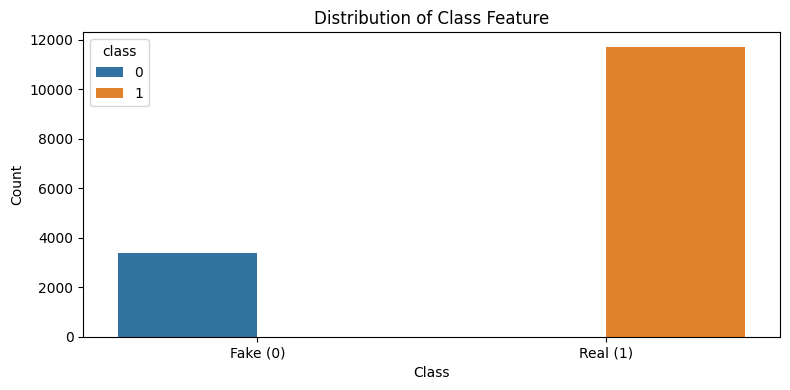

In [28]:
# Visualize Class Distribuction
plt.figure(figsize=(8, 4))
sns.barplot(x='class', y='class', data=data, estimator=len, hue='class')

# Add labels and title 
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Class Feature')
plt.xticks([0, 1], ['Fake (0)', 'Real (1)']) 
plt.tight_layout()
plt.show()

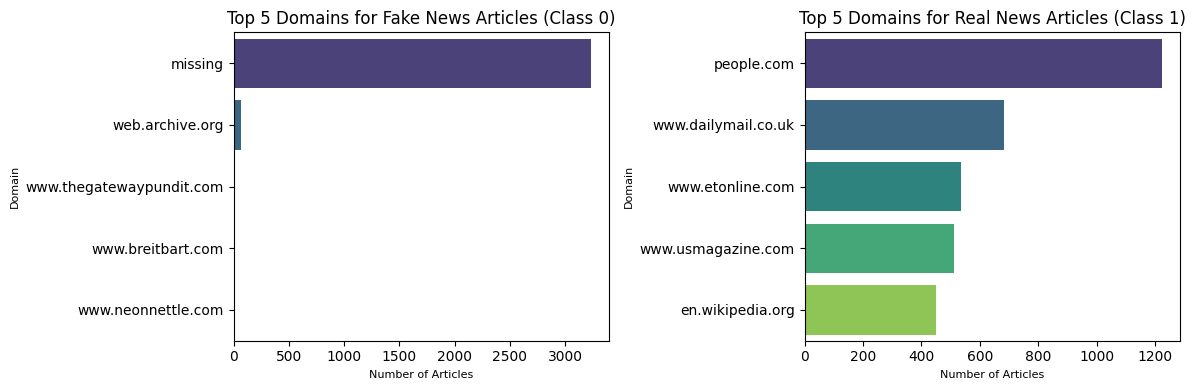

In [79]:
# Visualize top 5 domains for fake news and real news
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot for class 0 (Fake News)
fake_data = data[data['class'] == 0]
domain_counts = fake_data['domain'].value_counts()
top_5_domains = domain_counts.nlargest(5)
sns.barplot(x=top_5_domains.values, y=top_5_domains.index, palette='viridis', ax=ax1)
ax1.set_title('Top 5 Domains for Fake News Articles (Class 0)', fontsize=12)
ax1.set_xlabel('Number of Articles', fontsize=8)
ax1.set_ylabel('Domain', fontsize=8)

# Plot for class 1 (Real News)
fake_data = data[data['class'] == 1]
domain_counts = fake_data['domain'].value_counts()
top_5_domains = domain_counts.nlargest(5)
sns.barplot(x=top_5_domains.values, y=top_5_domains.index, palette='viridis', ax=ax2)
ax2.set_title('Top 5 Domains for Real News Articles (Class 1)', fontsize=12)
ax2.set_xlabel('Number of Articles', fontsize=8)
ax2.set_ylabel('Domain', fontsize=8)

plt.tight_layout()
plt.show()

#### **Word Clouds**

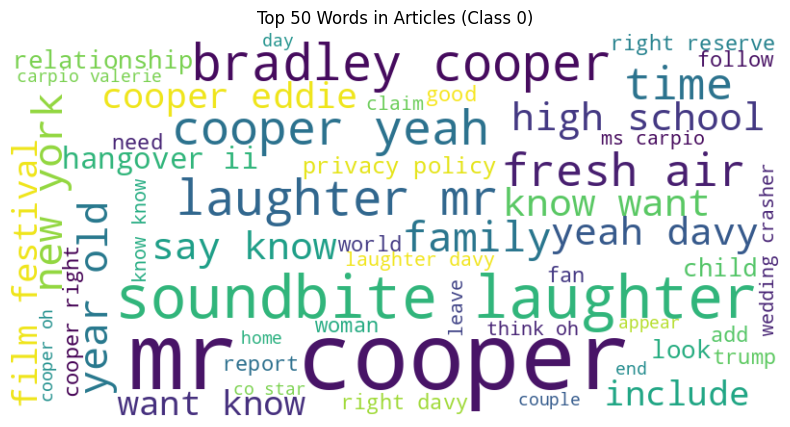

In [71]:
# Filter data for class 0
class_0_data = data[data['class'] == 0]

# Combine all text from extracted_article_text
text = ' '.join(class_0_data['spacy_text'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Words in Articles (Class 0)')
plt.show()

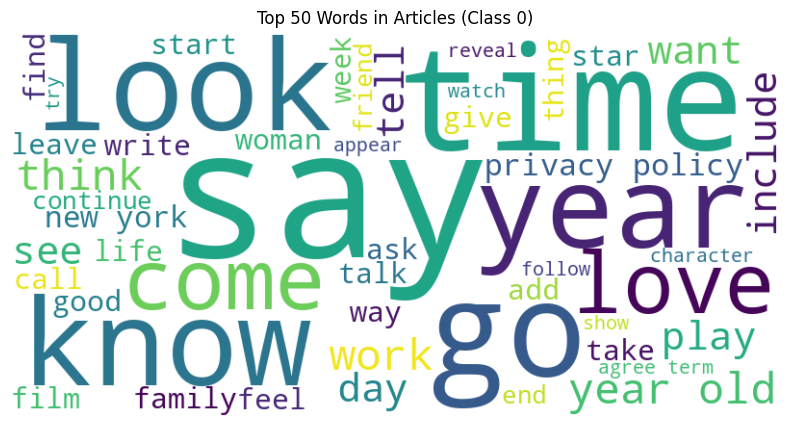

In [72]:
# Filter data for class 1
class_0_data = data[data['class'] == 1]

# Combine all text from extracted_article_text
text = ' '.join(class_0_data['spacy_text'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Words in Articles (Class 0)')
plt.show()

#### **Top N-grams**

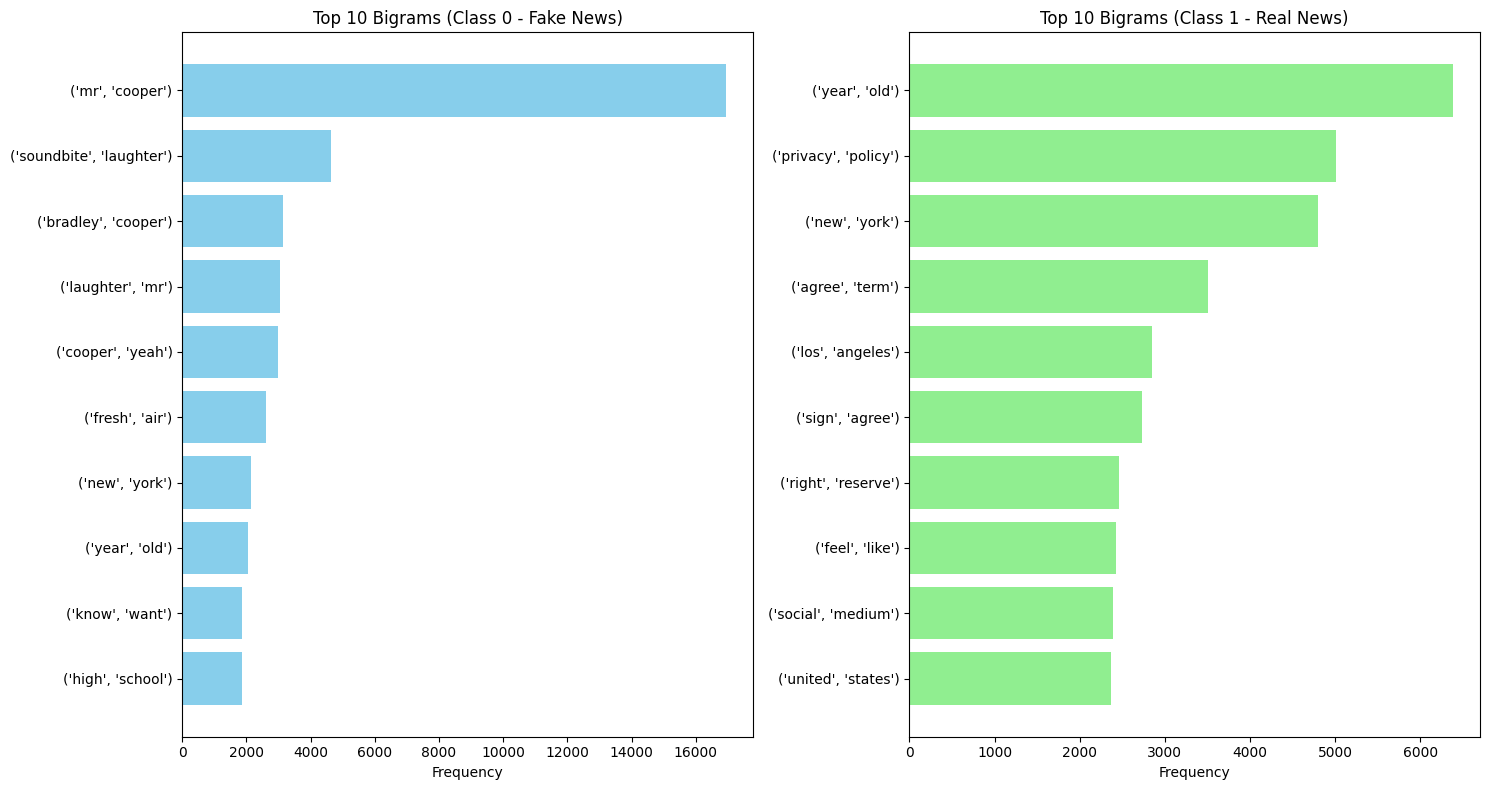

In [87]:
# Filter and plot top-10 bigrams for both fake and real news articles
def get_top_bigrams(text_series):
    all_bigrams = []
    for text in text_series.dropna():
        tokens = word_tokenize(text.lower())
        bigram_list = list(bigrams(tokens))
        all_bigrams.extend(bigram_list)
    return Counter(all_bigrams).most_common(10)

class_0_data = data[data['class'] == 0]['spacy_text']
class_1_data = data[data['class'] == 1]['spacy_text']

# Get top 10 bigrams for each class
top_bigrams_class_0 = get_top_bigrams(class_0_data)
top_bigrams_class_1 = get_top_bigrams(class_1_data)
bigrams_0, counts_0 = zip(*sorted(top_bigrams_class_0, key=lambda x: x[1], reverse=False))
bigrams_1, counts_1 = zip(*sorted(top_bigrams_class_1, key=lambda x: x[1], reverse=False))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# Plot for class 0
ax1.barh([str(bg) for bg in bigrams_0], counts_0, color='skyblue')
ax1.set_title('Top 10 Bigrams (Class 0 - Fake News)')
ax1.set_xlabel('Frequency')
# Plot for class 1
ax2.barh([str(bg) for bg in bigrams_1], counts_1, color='lightgreen')
ax2.set_title('Top 10 Bigrams (Class 1 - Real News)')
ax2.set_xlabel('Frequency')
plt.tight_layout()
plt.show()

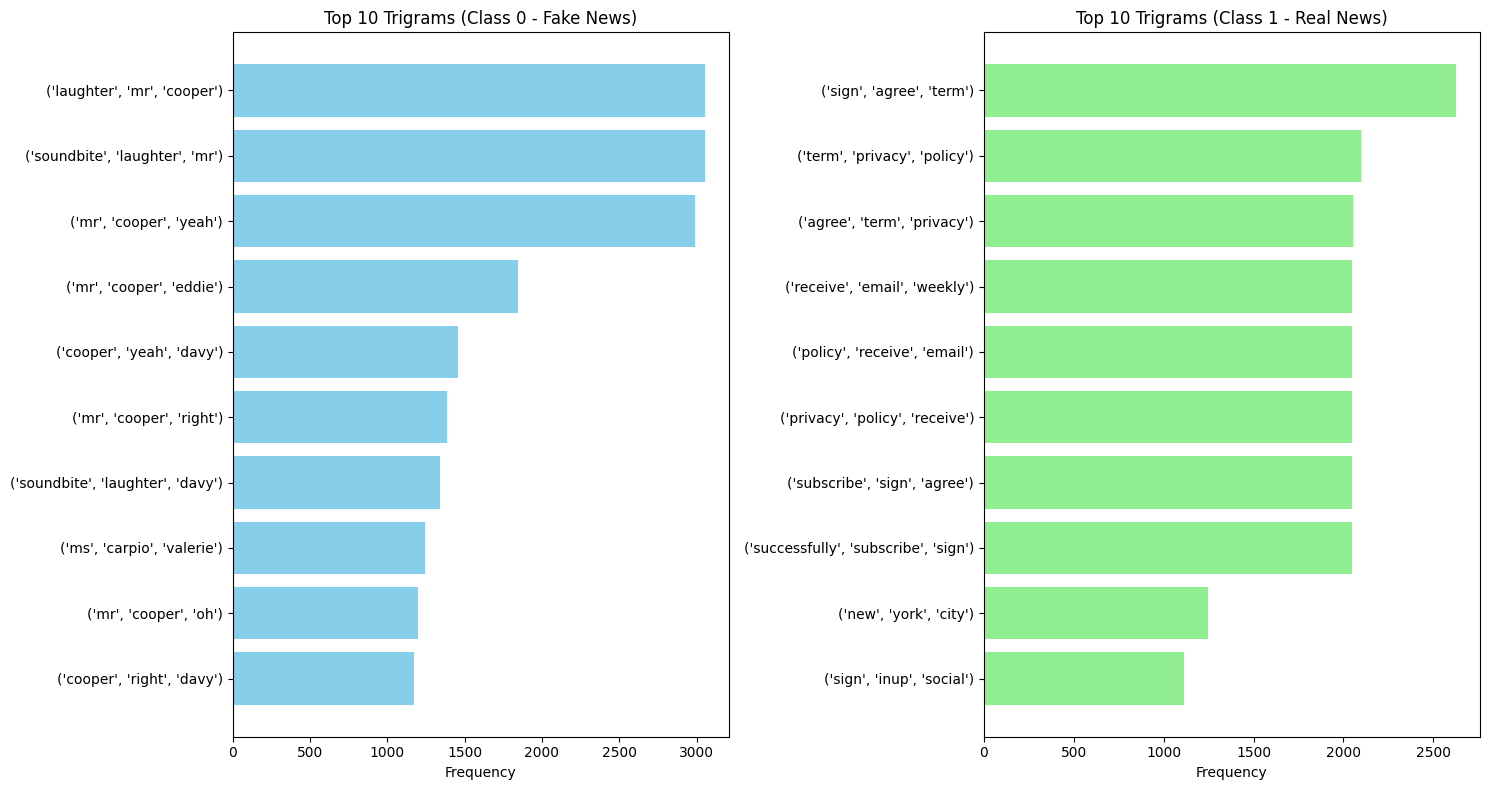

In [88]:
# Filter and plot top-10 trigrams for both fake and real news articles
def get_top_trigrams(text_series):
    all_trigrams = []
    for text in text_series.dropna():
        tokens = word_tokenize(text.lower())
        trigram_list = list(trigrams(tokens))
        all_trigrams.extend(trigram_list)
    return Counter(all_trigrams).most_common(10)

# Filter data for class 0 and class 1
class_0_data = data[data['class'] == 0]['spacy_text']
class_1_data = data[data['class'] == 1]['spacy_text']
top_trigrams_class_0 = get_top_trigrams(class_0_data)
top_trigrams_class_1 = get_top_trigrams(class_1_data)
trigrams_0, counts_0 = zip(*sorted(top_trigrams_class_0, key=lambda x: x[1], reverse=False))
trigrams_1, counts_1 = zip(*sorted(top_trigrams_class_1, key=lambda x: x[1], reverse=False))

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# Plot for class 0
ax1.barh([str(tg) for tg in trigrams_0], counts_0, color='skyblue')
ax1.set_title('Top 10 Trigrams (Class 0 - Fake News)')
ax1.set_xlabel('Frequency')
# Plot for class 1
ax2.barh([str(tg) for tg in trigrams_1], counts_1, color='lightgreen')
ax2.set_title('Top 10 Trigrams (Class 1 - Real News)')
ax2.set_xlabel('Frequency')
plt.tight_layout()
plt.show()

****

## Modelling

In [93]:
# Create a copy of data
df = data.copy()

# Define endog and exog
endog = df["class"]
exog = df[['text_length', 'num_sentences', 'spacy_text']]

# First train-test split (70-30)
X_temp, X_test, y_temp, y_test = train_test_split(exog, endog, test_size=0.3, random_state=42)

# Second split temp into train and validation (70-30 of remaining 70%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

# Separate numeric features for standardization
# numeric_features = exog[['text_length', 'num_sentences']]

In [94]:
# Initialize StandardScaler
scaler = StandardScaler() 
# Standardize numeric features
X_train_numeric = scaler.fit_transform(X_train[['text_length', 'num_sentences']])
X_val_numeric = scaler.transform(X_val[['text_length', 'num_sentences']])
X_test_numeric = scaler.transform(X_test[['text_length', 'num_sentences']])

In [95]:
# Tokenize text feature for Word2Vec
def tokenize_text(text_series):
    return [word_tokenize(text.lower()) for text in text_series.dropna()]
tokenized_spacy_text = tokenize_text(exog['spacy_text'])

# Train Word2Vec model on the tokenized text
word2vec_model = Word2Vec(sentences=tokenized_spacy_text, vector_size=100, window=5, min_count=1, workers=4)

# Function to get average Word2Vec vector for a text
def get_word2vec_vector(text, model, vector_size=100):
    words = word_tokenize(text.lower())
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

# Vectorize spacy_text using Word2Vec
X_train_spacy = np.array([get_word2vec_vector(text, word2vec_model) for text in X_train['spacy_text']])
X_val_spacy = np.array([get_word2vec_vector(text, word2vec_model) for text in X_val['spacy_text']])
X_test_spacy = np.array([get_word2vec_vector(text, word2vec_model) for text in X_test['spacy_text']])

In [ ]:
# # Load pretrained Word2Vec model (Google News 300-dim)
# def load_pretrained_model():
#     try:
#         # Try loading from local cache if available
#         return api.load("word2vec-google-news-300")
#     except ValueError:
#         # Fallback to glove-wiki-gigaword-300 if Google News unavailable
#         return api.load("glove-wiki-gigaword-300")

# pretrained_model = load_pretrained_model()

# # Function to get average vector using pretrained model
# def get_word2vec_vector(text, model):
#     words = word_tokenize(text.lower())
#     vector_size = model.vector_size
#     word_vectors = [model[word] for word in words if word in model.key_to_index]
#     if len(word_vectors) == 0:
#         return np.zeros(vector_size)
#     return np.mean(word_vectors, axis=0)

# # Vectorize text features
# X_train_spacy = np.array([get_word2vec_vector(text, pretrained_model) for text in X_train['spacy_text']])
# X_val_spacy = np.array([get_word2vec_vector(text, pretrained_model) for text in X_val['spacy_text']])
# X_test_spacy = np.array([get_word2vec_vector(text, pretrained_model) for text in X_test['spacy_text']])

In [96]:
# Combine standardized numeric features with Word2Vec vectors
X_train_combined = np.hstack((X_train_numeric, X_train_spacy))
X_val_combined = np.hstack((X_val_numeric, X_val_spacy))
X_test_combined = np.hstack((X_test_numeric, X_test_spacy))

# Print shapes to verify
print("X_train_combined shape:", X_train_combined.shape)
print("X_val_combined shape:", X_val_combined.shape)
print("X_test_combined shape:", X_test_combined.shape)

X_train_combined shape: (7406, 102)
X_val_combined shape: (3175, 102)
X_test_combined shape: (4535, 102)


### Objective 1: Build a Baseline Model to Predict Class of an Article 

Cross-Validation Scores: [0.83703354 0.84120983 0.8194707  0.83506616 0.83034026]
Average CV Score: 0.8326240989094493
Standard Deviation: 0.007447810699057965

Test Accuracy: 0.8196251378169791

Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.37      0.49      1083
           1       0.83      0.96      0.89      3452

    accuracy                           0.82      4535
   macro avg       0.79      0.66      0.69      4535
weighted avg       0.81      0.82      0.80      4535



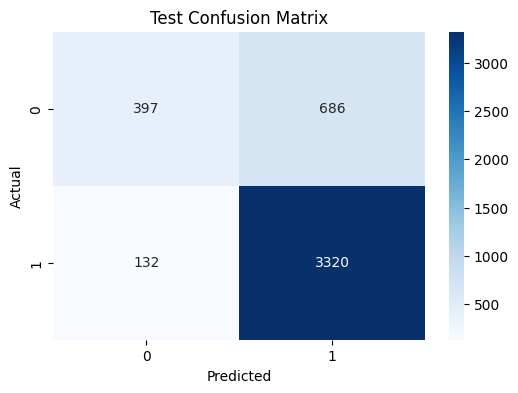

In [103]:
# Initialize and fit a logistic regression model
X_train_logistic = np.vstack((X_train_combined, X_val_combined))
y_train_logistic = np.hstack((y_train, y_val))

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Perform 5-fold cross-validation on the combined train + validation set
cv_scores = cross_val_score(model, X_train_logistic, y_train_logistic, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

# Fit the model and predict on test set
model.fit(X_train_logistic, y_train_logistic)
y_test_pred = model.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nTest Accuracy:", test_accuracy)
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Objective 2: Build an Ensemble Model to Predict Class of an Article 

Cross-Validation Scores: [0.83703354 0.84168242 0.83695652 0.8379017  0.83128544]
Average CV Score: 0.8369719249964058
Standard Deviation: 0.003328463335340162

Test Accuracy: 0.8251378169790519

Test Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.44      0.55      1083
           1       0.84      0.95      0.89      3452

    accuracy                           0.83      4535
   macro avg       0.78      0.69      0.72      4535
weighted avg       0.81      0.83      0.81      4535



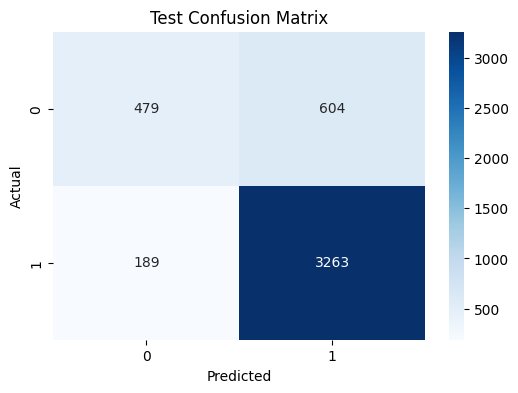

In [104]:
# Initialize and fit an XGBoost model
X_train_xgb = np.vstack((X_train_combined, X_val_combined))
y_train_xgb = np.hstack((y_train, y_val))

# Initialize the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform 5-fold cross-validation on the combined train + validation set
cv_scores = cross_val_score(model, X_train_xgb, y_train_xgb, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Average CV Score:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

# Fit the model on the entire train + validation set
model.fit(X_train_xgb, y_train_xgb)

# Predict on test set
y_test_pred = model.predict(X_test_combined)

# Evaluate performance on test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nTest Accuracy:", test_accuracy)

# Detailed classification report for test set
print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Objective 3: Build an LSTM Neural Network to Predict Class of an Article 

In [111]:
# Initialize and fit an LSTM neural network using Keras functional API

# Define Parameters 
max_len = 300  # Max tokens per sample
embedding_dim = 100  # As set in Word2Vec

# Convert text to padded sequences of Word2Vec vectors
def text_to_vector_sequence(text, model, max_len=300, embedding_dim=100):
    tokens = word_tokenize(text.lower())
    sequence = [model.wv[token] for token in tokens if token in model.wv]
    
    if len(sequence) == 0:
        return np.zeros((max_len, embedding_dim))

    # Truncate if too long
    sequence = sequence[:max_len]
    
    # Pad if too short
    if len(sequence) < max_len:
        padding = np.zeros((max_len - len(sequence), embedding_dim))
        sequence = np.vstack((sequence, padding))
    
    return np.array(sequence)

# Vectorize all text sets into 3D arrays
X_train_seq = np.array([text_to_vector_sequence(text, word2vec_model, max_len, embedding_dim) for text in X_train['spacy_text']])
X_val_seq = np.array([text_to_vector_sequence(text, word2vec_model, max_len, embedding_dim) for text in X_val['spacy_text']])
X_test_seq = np.array([text_to_vector_sequence(text, word2vec_model, max_len, embedding_dim) for text in X_test['spacy_text']])

In [114]:
# Define LSTM architecture
inputs = Input(shape=(max_len, embedding_dim))
x = Masking(mask_value=0.0)(inputs)  # Handles zero-padding
x = LSTM(64)(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 100)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 300, 100)  │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 300, 100)  │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 300)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     42,240 │ masking[0][0],    │
│                     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,353 (173.25 KB)

 Trainable params: 44,353 (173.25 KB)

 Non-trainable params: 0 (0.00 B)

In [116]:
# Fit
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=64)

# predict
y_pred_probs = model.predict(X_test_seq)
y_pred = (y_pred_probs > 0.5).astype("int32")

Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8413 - loss: 0.3892 - val_accuracy: 0.8331 - val_loss: 0.4028
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8467 - loss: 0.3628 - val_accuracy: 0.8079 - val_loss: 0.4692
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8311 - loss: 0.4007 - val_accuracy: 0.8239 - val_loss: 0.4093
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8533 - loss: 0.3477 - val_accuracy: 0.8287 - val_loss: 0.4471
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8718 - loss: 0.3151 - val_accuracy: 0.8205 - val_loss: 0.4124
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8838 - loss: 0.2813 - val_accuracy: 0.8239 - val_loss: 0.4143
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8972 - loss: 0.2695 - val_accuracy: 0.8296 - val_loss: 0.4305
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9075 - loss: 0.2383 - val_accu

Test Accuracy: 0.8083792723263507

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.46      0.54      1083
           1       0.84      0.92      0.88      3452

    accuracy                           0.81      4535
   macro avg       0.74      0.69      0.71      4535
weighted avg       0.79      0.81      0.80      4535



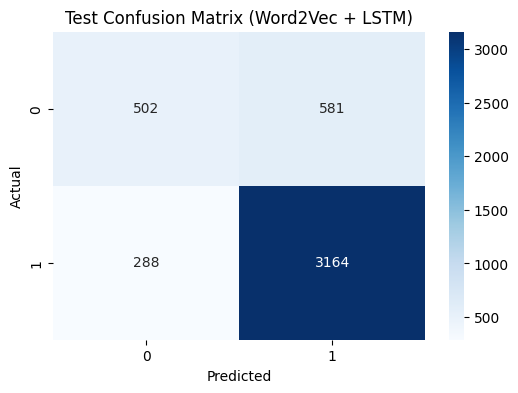

In [119]:
# Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Test Confusion Matrix (Word2Vec + LSTM)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Objective 4: Leverage Transfer Learning to Finetune Pretrained Transformers 

#### **RoBERTa**

In [191]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize RoBERTa model and tokenizer
model_name = "roberta-base"
roberta_tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    hidden_dropout_prob=0.2,    # Increased regularization
    attention_probs_dropout_prob=0.2
).to(device)

Using device: cuda


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [192]:
# Prepare dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt"
        )
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
        
    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = NewsDataset(X_train['spacy_text'].tolist(), y_train.tolist(), roberta_tokenizer)
val_dataset = NewsDataset(X_val['spacy_text'].tolist(), y_val.tolist(), roberta_tokenizer)
test_dataset = NewsDataset(X_test['spacy_text'].tolist(), y_test.tolist(), roberta_tokenizer)

In [193]:
# Metrics tracker
class MetricsTracker:
    def __init__(self):
        self.epoch_data = []
    
    def log_epoch(self, epoch, metrics):
        metrics['epoch'] = epoch
        self.epoch_data.append(metrics)
    
    def get_dataframe(self):
        return pd.DataFrame(self.epoch_data).set_index('epoch')

metrics_tracker = MetricsTracker()

# Performance metrics calculation
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(p.label_ids, preds),
        'precision': precision_score(p.label_ids, preds, zero_division=0),
        'recall': recall_score(p.label_ids, preds, zero_division=0),
        'f1': f1_score(p.label_ids, preds, zero_division=0),
        'roc_auc': roc_auc_score(p.label_ids, probs)
   }
    return metrics

In [194]:
# Training configuration optimized for finetuning the RoBERTa transformer
training_args = TrainingArguments(
    output_dir='./roberta_results',
    run_name='roberta-fake-news-detection',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,  # Slightly lower than BERT
    warmup_ratio=0.06,   # 6% warmup steps
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',  # Focus on balanced metric
    greater_is_better=True,
    logging_dir='./roberta_logs',
    logging_steps=100,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to='none',
    save_total_limit=2
)

In [195]:
# Custom trainer for metrics tracking
class CustomTrainer(Trainer):
    def evaluate(self, *args, **kwargs):
        metrics = super().evaluate(*args, **kwargs)
        metrics_tracker.log_epoch(self.state.epoch, metrics)
        return metrics

# Initialize trainer
roberta_trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [196]:
# Train model
print("Fine-tuning RoBERTa for fake news detection...")
roberta_trainer.train()

# Display training metrics
training_metrics = metrics_tracker.get_dataframe()
print("\nTraining Metrics by Epoch:")
print(training_metrics.round(4).to_markdown())

# Evaluate on test set
test_results = roberta_trainer.predict(test_dataset)
test_metrics = compute_metrics(test_results)

# Format predictions
y_pred = np.argmax(test_results.predictions, axis=1)
y_probs = torch.softmax(torch.tensor(test_results.predictions), dim=1).numpy()[:, 1]

# Performance report
print("\n\n=== FINAL TEST PERFORMANCE ===")
print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")
print(f"F1 Score:  {test_metrics['f1']:.4f}")
print(f"ROC-AUC:   {test_metrics['roc_auc']:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake (0)', 'Real (1)']))

Fine-tuning RoBERTa for fake news detection...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.466200,0.406790,0.830866,0.854334,0.944825,0.897303,0.812419
2,0.398500,0.404203,0.846929,0.855465,0.967781,0.908163,0.831672
3,0.349800,0.374937,0.853858,0.870187,0.955699,0.910940,0.846962
4,0.329200,0.378884,0.853858,0.878515,0.943617,0.909903,0.848993



Training Metrics by Epoch:
|   epoch |   eval_loss |   eval_accuracy |   eval_precision |   eval_recall |   eval_f1 |   eval_roc_auc |
|--------:|------------:|----------------:|-----------------:|--------------:|----------:|---------------:|
|       1 |      0.4068 |          0.8309 |           0.8543 |        0.9448 |    0.8973 |         0.8124 |
|       2 |      0.4042 |          0.8469 |           0.8555 |        0.9678 |    0.9082 |         0.8317 |
|       3 |      0.3749 |          0.8539 |           0.8702 |        0.9557 |    0.9109 |         0.847  |
|       4 |      0.3789 |          0.8539 |           0.8785 |        0.9436 |    0.9099 |         0.849  |




=== FINAL TEST PERFORMANCE ===
Accuracy:  0.8408
Precision: 0.8522
Recall:    0.9568
F1 Score:  0.9015
ROC-AUC:   0.8459

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.77      0.47      0.59      1083
    Real (1)       0.85      0.96      0.90      3452

    accuracy                           0.84      4535
   macro avg       0.81      0.71      0.74      4535
weighted avg       0.83      0.84      0.83      4535



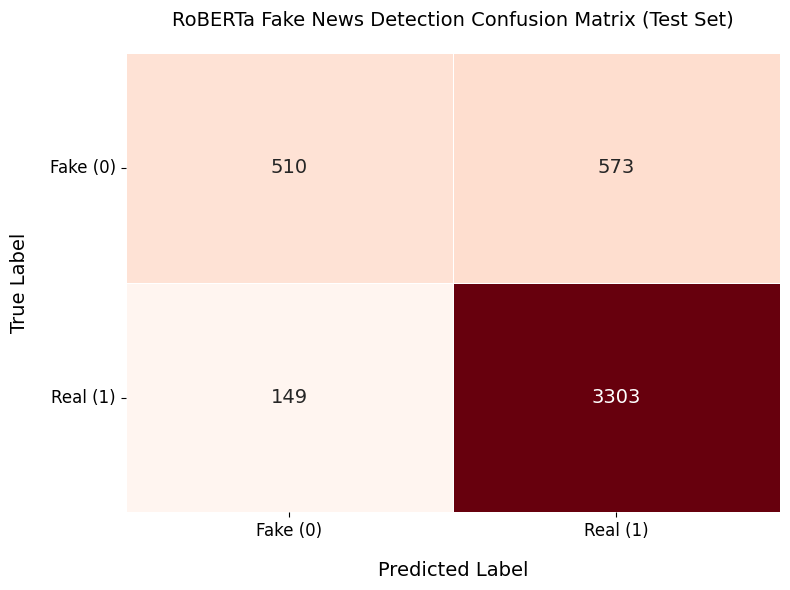

In [197]:
# Confusion matrix with RoBERTa-specific styling
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt='d', 
    cmap='Reds',
    cbar=False,
    annot_kws={'size': 14},
    linewidths=0.5
)
plt.title('RoBERTa Fake News Detection Confusion Matrix (Test Set)', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=15)
plt.ylabel('True Label', fontsize=14, labelpad=15)
plt.xticks([0.5, 1.5], ['Fake (0)', 'Real (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['Fake (0)', 'Real (1)'], fontsize=12, rotation=0)
plt.tight_layout()
plt.savefig('roberta_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [198]:
# Print first five predictions made by the finetuned RoBERTa transformer
roberta_results = pd.DataFrame({
    'preprocessed_article_text': X_test['spacy_text'],
    'true_label': y_test,
    'predicted_label': y_pred,
    'real_prob': y_probs,
    'correct': y_test == y_pred
})
roberta_results.head()

,preprocessed_article_text,true_label,predicted_label,real_prob,correct
5588,watch kelly ripa hilariously audition american...,1,1,0.970101,True
6838,stranger thing kid singe motown medley james c...,1,1,0.969174,True
13407,liam payne cheryl split year tough decision li...,1,1,0.976269,True
1607,scott disick say date kourtney kardashian fulf...,1,1,0.943857,True
5578,ian somerhalder star netflix vampire drama ser...,1,1,0.983453,True


In [199]:
# Define the path to save the finetuned RoBERTa model
model_path = "/kaggle/working/roberta_model"

# Save the model
roberta_trainer.save_model(model_path)

# Save the tokenizer
roberta_tokenizer.save_pretrained(model_path)

print(f"Model saved to {model_path}")

# Save in a zipped downloadable format
!mkdir -p /kaggle/working/roberta_model_zip
!cp -r {model_path}/* /kaggle/working/roberta_model_zip/
!zip -r /kaggle/working/roberta_model.zip /kaggle/working/roberta_model_zip

print("Model zipped and ready for download")

Model saved to /kaggle/working/roberta_model
updating: kaggle/working/roberta_model_zip/ (stored 0%)
updating: kaggle/working/roberta_model_zip/model.safetensors (deflated 12%)
updating: kaggle/working/roberta_model_zip/training_args.bin (deflated 52%)
updating: kaggle/working/roberta_model_zip/vocab.json (deflated 68%)
updating: kaggle/working/roberta_model_zip/config.json (deflated 50%)
updating: kaggle/working/roberta_model_zip/tokenizer_config.json (deflated 76%)
updating: kaggle/working/roberta_model_zip/merges.txt (deflated 53%)
updating: kaggle/working/roberta_model_zip/special_tokens_map.json (deflated 84%)
Model zipped and ready for download


In [188]:
from IPython.display import FileLink
import os

# Compress the model directory
!zip -r /kaggle/working/roberta_model.zip /kaggle/working/roberta_model

# Create download link
FileLink('/kaggle/working/roberta_model.zip')

updating: kaggle/working/roberta_model/ (stored 0%)
updating: kaggle/working/roberta_model/model.safetensors (deflated 12%)
updating: kaggle/working/roberta_model/training_args.bin (deflated 52%)
updating: kaggle/working/roberta_model/vocab.json (deflated 68%)
updating: kaggle/working/roberta_model/config.json (deflated 50%)
updating: kaggle/working/roberta_model/tokenizer_config.json (deflated 76%)
updating: kaggle/working/roberta_model/merges.txt (deflated 53%)
updating: kaggle/working/roberta_model/special_tokens_map.json (deflated 84%)


/kaggle/working/roberta_model.zip

#### **BERT**

In [139]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    hidden_dropout_prob=0.2,    # Increased regularization
    attention_probs_dropout_prob=0.2
).to(device)

Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [140]:
# Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt"
        )
        self.labels = torch.tensor(labels, dtype=torch.long)
        
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }
        
    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = NewsDataset(X_train['spacy_text'].tolist(), y_train.tolist(), tokenizer)
val_dataset = NewsDataset(X_val['spacy_text'].tolist(), y_val.tolist(), tokenizer)
test_dataset = NewsDataset(X_test['spacy_text'].tolist(), y_test.tolist(), tokenizer)

In [146]:
# Metrics tracker
class MetricsTracker:
    def __init__(self):
        self.epoch_data = []
    
    def log_epoch(self, epoch, metrics):
        metrics['epoch'] = epoch
        self.epoch_data.append(metrics)
    
    def get_dataframe(self):
        return pd.DataFrame(self.epoch_data).set_index('epoch')

metrics_tracker = MetricsTracker()

# Performance metrics calculation
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(p.label_ids, preds),
        'precision': precision_score(p.label_ids, preds, zero_division=0),
        'recall': recall_score(p.label_ids, preds, zero_division=0),
        'f1': f1_score(p.label_ids, preds, zero_division=0),
        'roc_auc': roc_auc_score(p.label_ids, probs)
   }
    return metrics

In [147]:
# Training configuration
training_args = TrainingArguments(
    output_dir='./bert_results',
    run_name='bert-fake-news-detection',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    logging_dir='./bert_logs',
    logging_steps=100,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to='none'
)

In [148]:
# Custom trainer for metrics tracking
class CustomTrainer(Trainer):
    def evaluate(self, *args, **kwargs):
        metrics = super().evaluate(*args, **kwargs)
        metrics_tracker.log_epoch(self.state.epoch, metrics)
        return metrics

# Initialize trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [149]:
# Train model
print("Fine-tuning BERT for fake news detection...")
trainer.train()

# Display training metrics
training_metrics = metrics_tracker.get_dataframe()
print("\nTraining Metrics by Epoch:")
print(training_metrics.round(4).to_markdown())

# Evaluate on test set
test_results = trainer.predict(test_dataset)
test_metrics = compute_metrics(test_results)

# Format predictions
y_pred = np.argmax(test_results.predictions, axis=1)
y_probs = torch.softmax(torch.tensor(test_results.predictions), dim=1).numpy()[:, 1]

# Performance report
print("\n\n=== FINAL TEST PERFORMANCE ===")
print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")
print(f"F1 Score:  {test_metrics['f1']:.4f}")
print(f"ROC-AUC:   {test_metrics['roc_auc']:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake (0)', 'Real (1)']))

Fine-tuning BERT for fake news detection...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc
1,0.296200,0.495461,0.792126,0.901012,0.824809,0.861228,0.833230
2,0.343700,0.427131,0.844724,0.844291,0.982682,0.908245,0.849356
3,0.266000,0.398239,0.849134,0.865160,0.956101,0.908360,0.858285
4,0.230200,0.423220,0.851339,0.875047,0.944825,0.908598,0.857063



Training Metrics by Epoch:
|   epoch |   eval_loss |   eval_accuracy |   eval_precision |   eval_recall |   eval_f1 |   eval_roc_auc |
|--------:|------------:|----------------:|-----------------:|--------------:|----------:|---------------:|
|       1 |      0.4955 |          0.7921 |           0.901  |        0.8248 |    0.8612 |         0.8332 |
|       2 |      0.4271 |          0.8447 |           0.8443 |        0.9827 |    0.9082 |         0.8494 |
|       3 |      0.3982 |          0.8491 |           0.8652 |        0.9561 |    0.9084 |         0.8583 |
|       4 |      0.4232 |          0.8513 |           0.875  |        0.9448 |    0.9086 |         0.8571 |




=== FINAL TEST PERFORMANCE ===
Accuracy:  0.8465
Precision: 0.8698
Recall:    0.9389
F1 Score:  0.9030
ROC-AUC:   0.8635

Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.74      0.55      0.63      1083
    Real (1)       0.87      0.94      0.90      3452

    accuracy                           0.85      4535
   macro avg       0.80      0.75      0.77      4535
weighted avg       0.84      0.85      0.84      4535



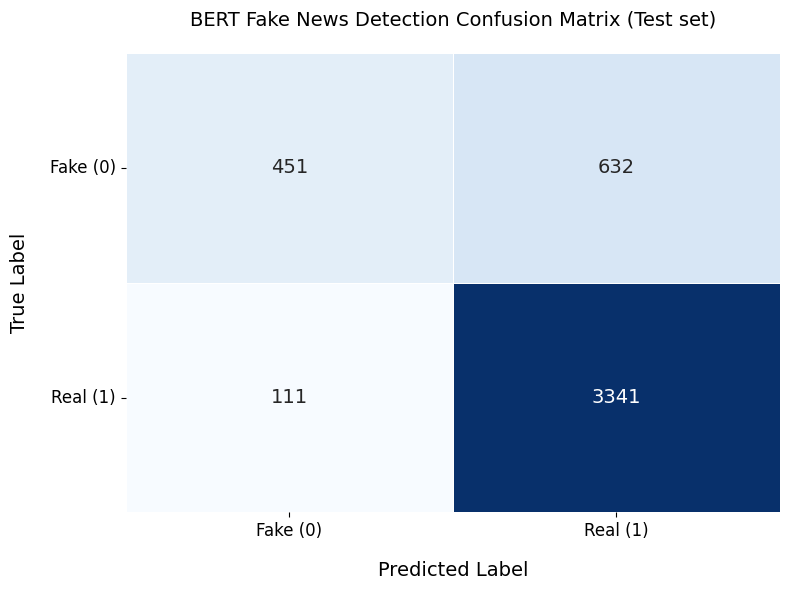

In [167]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    cbar=False,
    annot_kws={'size': 14},
    linewidths=0.5
)
plt.title('BERT Fake News Detection Confusion Matrix (Test set)', fontsize=14, pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=15)
plt.ylabel('True Label', fontsize=14, labelpad=15)
plt.xticks([0.5, 1.5], ['Fake (0)', 'Real (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['Fake (0)', 'Real (1)'], fontsize=12, rotation=0)
plt.tight_layout()
plt.savefig('bert_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [168]:
# Print first five predictions made by the finetuned BERT transformer
bert_results = pd.DataFrame({
    'preprocessed_article_text': X_test['spacy_text'],
    'true_label': y_test,
    'predicted_label': y_pred,
    'real_prob': y_probs,
    'correct': y_test == y_pred
})
bert_results.head()

,preprocessed_article_text,true_label,predicted_label,real_prob,correct
5588,watch kelly ripa hilariously audition american...,1,1,0.961381,True
6838,stranger thing kid singe motown medley james c...,1,1,0.961006,True
13407,liam payne cheryl split year tough decision li...,1,1,0.955295,True
1607,scott disick say date kourtney kardashian fulf...,1,1,0.961125,True
5578,ian somerhalder star netflix vampire drama ser...,1,1,0.962483,True


#### **Longformer**

In [ ]:
from transformers import LongformerTokenizer, LongformerForSequenceClassification, Trainer, TrainingArguments
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Longformer model and tokenizer
model_name = "allenai/longformer-base-4096"
longformer_tokenizer = LongformerTokenizer.from_pretrained(model_name)
model = LongformerForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    attention_window=512,  
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
).to(device)

In [ ]:
# Dataset class with Longformer-specific processing
class LongNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=2048):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __getitem__(self, idx):
        text = self.texts[idx]
        
        # Longformer requires global attention on [CLS] token
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Create global attention mask - put 1 on [CLS] token, 0 elsewhere
        global_attention_mask = torch.zeros_like(encoding['input_ids'])
        global_attention_mask[:, 0] = 1  # Global attention on [CLS]
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'global_attention_mask': global_attention_mask.squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        
    def __len__(self):
        return len(self.texts)

# Create datasets (using longer sequence length)
print("Tokenizing datasets...")
start_time = time.time()
train_dataset = LongNewsDataset(X_train['spacy_text'].tolist(), y_train.tolist(), longformer_tokenizer, max_length=2048)
val_dataset = LongNewsDataset(X_val['spacy_text'].tolist(), y_val.tolist(), longformer_tokenizer, max_length=2048)
test_dataset = LongNewsDataset(X_test['spacy_text'].tolist(), y_test.tolist(), longformer_tokenizer, max_length=2048)
print(f"Tokenization completed in {time.time()-start_time:.2f} seconds")

In [ ]:
# Metrics tracker
class LongformerMetricsTracker:
    def __init__(self):
        self.epoch_data = []
    
    def log_epoch(self, epoch, metrics):
        metrics['epoch'] = epoch
        self.epoch_data.append(metrics)
    
    def get_dataframe(self):
        return pd.DataFrame(self.epoch_data).set_index('epoch')

metrics_tracker = LongformerMetricsTracker()

# Performance metrics calculation
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    probs = torch.softmax(torch.tensor(p.predictions), dim=1).numpy()[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(p.label_ids, preds),
        'precision': precision_score(p.label_ids, preds, zero_division=0),
        'recall': recall_score(p.label_ids, preds, zero_division=0),
        'f1': f1_score(p.label_ids, preds, zero_division=0),
        'roc_auc': roc_auc_score(p.label_ids, probs)
   }
    return metrics

In [ ]:
# Training configuration optimized for Longformer
training_args = TrainingArguments(
    output_dir='./longformer_results',
    run_name='longformer-fake-news-detection',
    num_train_epochs=4,  # Fewer epochs due to longer sequences
    per_device_train_batch_size=2,   # Smaller batch size for memory constraints
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,   # Compensate for small batch size
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='roc_auc',
    greater_is_better=True,
    logging_dir='./longformer_logs',
    logging_steps=50,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to='none',
    save_total_limit=2  # Limit checkpoints to save space
)

In [ ]:
# Custom trainer for metrics tracking
class LongformerTrainer(Trainer):
    def evaluate(self, *args, **kwargs):
        metrics = super().evaluate(*args, **kwargs)
        metrics_tracker.log_epoch(self.state.epoch, metrics)
        return metrics

# Initialize trainer
longformer_trainer = LongformerTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Train model
print("Fine-tuning Longformer for fake news detection...")
start_train = time.time()
longformer_trainer.train()
print(f"Training completed in {(time.time()-start_train)/60:.2f} minutes")

# Display training metrics
training_metrics = metrics_tracker.get_dataframe()
print("\nTraining Metrics by Epoch:")
print(training_metrics.round(4).to_markdown())

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.predict(test_dataset)
test_metrics = compute_metrics(test_results)

# Format predictions
y_pred = np.argmax(test_results.predictions, axis=1)
y_probs = torch.softmax(torch.tensor(test_results.predictions), dim=1).numpy()[:, 1]

# Performance report
print("\n\n=== LONGFORMER TEST PERFORMANCE ===")
print(f"Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")
print(f"F1 Score:  {test_metrics['f1']:.4f}")
print(f"ROC-AUC:   {test_metrics['roc_auc']:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake (0)', 'Real (1)']))

In [ ]:
# Confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt='d', 
    cmap='Purples',
    cbar=False,
    annot_kws={'size': 14},
    linewidths=0.5
)
plt.title('Longformer Fake News Detection\nTest Confusion Matrix', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=14, labelpad=15)
plt.ylabel('True Label', fontsize=14, labelpad=15)
plt.xticks([0.5, 1.5], ['Fake (0)', 'Real (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['Fake (0)', 'Real (1)'], fontsize=12, rotation=0)
plt.tight_layout()
plt.savefig('longformer_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Print first five predictions made by the finetuned Longformer transformer
longformer_results = pd.DataFrame({
    'preprocessed_article_text': X_test['spacy_text'],
    'true_label': y_test,
    'predicted_label': y_pred,
    'real_prob': y_probs,
    'correct': y_test == y_pred
})
longformer_results.head()

In [ ]:
# Define the path to save the finetuned Longformer model
model_path = "/kaggle/working/longformer_model"

# Save the model
longformer_trainer.save_model(model_path)

# Save the tokenizer
longformer_tokenizer.save_pretrained(model_path)

print(f"Model saved to {model_path}")

# Save in a zipped downloadable format
!mkdir -p /kaggle/working/longformer_model_zip
!cp -r {model_path}/* /kaggle/working/longformer_model_zip/
!zip -r /kaggle/working/longformer_model.zip /kaggle/working/longformer_model_zip

print("Model zipped and ready for download")

## Evaluation

### Objective 5: Compare Respective Performance on test set to Determine Deployment Model

## Model Interpretability

## Deployment

## Conclusion and Recomendations

### Conclusion

### Recommendations

## Next Steps